# baseline NCA
從 **E1-1_GNCA** 簡化找到最基本的NCA架構

In [1]:
# 1. 標準庫
import sys
import os
import io
import json
import glob

# 2. 第三方套件
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from keras import layers, models, optimizers, losses, metrics
import tqdm
from IPython.display import clear_output, display, HTML

# 3. 影片相關

import cv2

# 4. 設定 project 路徑（依你本機路徑調整）
project_root = "C:/Users/GAI/Desktop/Scott/NCA_Research"
if project_root not in sys.path:
    sys.path.append(project_root)

# 5. IPython 魔法指令（Jupyter專用）
%reload_ext autoreload
%autoreload 2

# 6. 共享 core_utils 函式庫導入
from core_utils.plotting import (
    plt_HWC_split_channels,
)

from core_utils.utils_io import (
    np2pil,      # numpy → PIL Image
    imwrite,     # 儲存圖像為檔案
    imencode,    # 編碼圖像為 byte stream
    im2url,      # 圖像轉 base64 URL（HTML 顯示用）
    load_emoji   # 載入 emoji 圖像
)

from core_utils.utils_image import (
    imshow,      # 在 notebook 顯示圖像
    tile2d,      # 多圖拼接
    zoom         # 放大圖像
)

from core_utils.utils_video import (
    save_video,  # 批次輸出影片
    VideoWriter  # 逐幀寫入影片（支援 context manager）
)

from core_utils.ops_tensor import (
    to_rgb,
    to_rgba,
    to_alpha
)


from core_utils.viz_train import (
    viz_pool,
    viz_batch,
    viz_loss
)


# 6. 實驗項目 utils 函式庫導入
from E1_basicGNCA.utils.SamplePool import SamplePool

clear_output()

# Global Params

In [2]:
#@title Cellular Automata Parameters
CHANNEL_N = 16        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 1024
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🦎" #@param {type:"string"}


USE_PATTERN_POOL = True


# load data

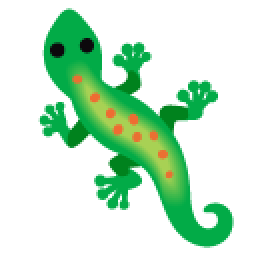

<class 'numpy.ndarray'> (128, 128, 4)


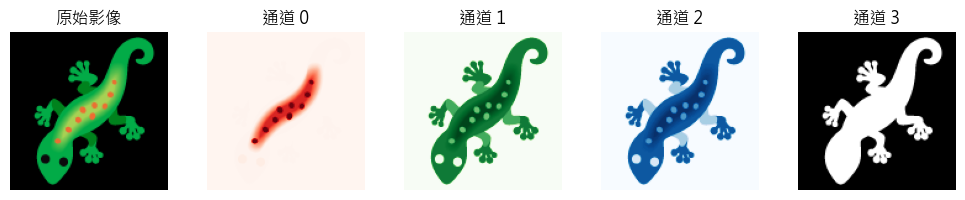

In [3]:
target_img = load_emoji(TARGET_EMOJI, max_size=TARGET_SIZE)
imshow(zoom(to_rgb(target_img), 2), fmt='png')
print(type(target_img), target_img.shape)
plt_HWC_split_channels(target_img)


# build Model

## func

In [4]:
def make_seed(size, n=1):
  x = np.zeros([n, size, size, CHANNEL_N], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x

## model

In [5]:


class CAModel(tf.keras.Model):

  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    self.dmodel = tf.keras.Sequential([
          layers.Conv2D(128, 1, activation=tf.nn.relu),
          layers.Conv2D(self.channel_n, 1, activation=None,
              kernel_initializer=tf.zeros_initializer),
    ])

    self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

  @tf.function
  def perceive(self, x, angle=0.0):
    identify = np.float32([0, 1, 0])
    identify = np.outer(identify, identify)
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
    dy = dx.T
    c, s = tf.cos(angle), tf.sin(angle)
    kernel = tf.stack([identify, c*dx-s*dy, s*dx+c*dy], -1)[:, :, None, :]
    kernel = tf.repeat(kernel, self.channel_n, 2)
    y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
    return y

  @tf.function
  def call(self, x, n_times=1):
    for _ in range(n_times):
      x = self.forward_pass(x)
    return x
  
  @tf.function
  def forward_pass(self, x,angle=0.0):
    y = self.perceive(x, angle)
    dx = self.dmodel(y)
    x += dx 
    return x


CAModel().dmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (1, 3, 3, 128)            6272      
                                                                 
 conv2d_1 (Conv2D)           (1, 3, 3, 16)             2064      
                                                                 
Total params: 8,336
Trainable params: 8,336
Non-trainable params: 0
_________________________________________________________________


# Training

## train setp

## loss_fn

In [6]:
def loss_f(x, target=None):
  return tf.reduce_mean(tf.square(to_rgba(x)-target), [-2, -3, -1])


## init train

In [7]:
# 設定目標圖像的 padding，避免邊界效應
p = TARGET_PADDING
target = tf.pad(target_img, [[p, p], [p, p], [0, 0]])

# 取得 padding 後影像尺寸
height, width = target.shape[:2]

# 建立 NCA 初始化的種子張量 seed，shape = (H, W, CHANNEL_N)
seed = np.zeros([height, width, CHANNEL_N], dtype=np.float32)

# 種子中心設定為活性狀態（通常是 alpha 或特定通道啟動）
seed[height // 2, width // 2, 3:] = 1.0  # 3: 代表從第四個通道開始

# 建立 NCA 模型實例
ca = CAModel()

# 設定學習率與階梯衰減學習率調度器
initial_lr = 2e-3
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[2000], values=[initial_lr, initial_lr * 0.1]
)


# 建立優化器，Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# 初始損失（以種子推論一次損失）
loss0 = loss_f(seed, target).numpy()

# 編譯模型以便儲存完整訓練資訊
ca.compile(optimizer=optimizer, loss=loss_f)

# 建立 SamplePool，儲存多個種子作為訓練樣本池
data={
    'x': np.repeat(seed[None, ...], POOL_SIZE, axis=0)
}
pool = SamplePool(data)


## train step

In [8]:
@tf.function
def train_step(x, target, model, loss_fn, optimizer):
  iter_n = tf.random.uniform([], 64, 96, tf.int32)
  with tf.GradientTape() as g:
    x = model(x, n_times=iter_n)
    loss = tf.reduce_mean(loss_fn(x, target))
  grads = g.gradient(loss, model.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  optimizer.apply_gradients(zip(grads, model.weights))
  return x, loss

In [9]:
def export_model(ca, base_fn):
  ca.save_weights(base_fn)

  cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, CHANNEL_N]),
      fire_rate=tf.constant(0.5),
      angle=tf.constant(0.0),
      step_size=tf.constant(1.0))
  cf = convert_to_constants.convert_variables_to_constants_v2(cf)
  graph_def = cf.graph.as_graph_def()
  graph_json = MessageToDict(graph_def)
  graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
  model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
  }
  with open(base_fn+'.json', 'w') as f:
    json.dump(model_json, f)

## run train

In [10]:
loss_log=[]
OUT_PATH = '../outputs/E1_2-baseline_NCA'
EPOCHS=4000+1

for i in range(EPOCHS+1):
  if USE_PATTERN_POOL:
    batch = pool.sample(BATCH_SIZE)
    x0 = batch.x
    loss_rank = loss_f(x0, target).numpy().argsort()[::-1]
    x0 = x0[loss_rank] 
    x0[:1] = seed
  else:
    x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)

  x, loss = train_step(x0, target, ca, loss_f, optimizer)

  if USE_PATTERN_POOL:
    batch.x[:] = x
    batch.commit()

  step_i = len(loss_log)
  loss_log.append(loss.numpy())
 

  if step_i%10 == 0:
    viz_pool(pool, step_i, output_path=f'{OUT_PATH}/pool')

  if step_i%100 == 0 and step_i > 0:
    clear_output()
    viz_batch(x0, x, step_i, output_path=f'{OUT_PATH}/batch')
    if step_i == EPOCHS+1:
      viz_loss(loss_log, save_path=f'{OUT_PATH}')
    else:
      viz_loss(loss_log)
    ca.save(f'{OUT_PATH}/saved_model/{step_i}')
    
  print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_1/conv2d_3/Conv2D' defined at (most recent call last):
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\tornado\platform\asyncio.py", line 211, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\GAI\AppData\Local\Temp\ipykernel_33876\2566950516.py", line 15, in <module>
      x, loss = train_step(x0, target, ca, loss_f, optimizer)
    File "C:\Users\GAI\AppData\Local\Temp\ipykernel_33876\517820259.py", line 5, in train_step
      x = model(x, n_times=iter_n)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\GAI\AppData\Local\Temp\ipykernel_33876\927943600.py", line 30, in call
      for _ in range(n_times):
    File "C:\Users\GAI\AppData\Local\Temp\ipykernel_33876\927943600.py", line 31, in call
      x = self.forward_pass(x)
    File "C:\Users\GAI\AppData\Local\Temp\ipykernel_33876\927943600.py", line 37, in forward_pass
      dx = self.dmodel(y)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\keras\layers\convolutional\base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "c:\Users\GAI\miniconda3\envs\tf-gpu\lib\site-packages\keras\layers\convolutional\base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_1/conv2d_3/Conv2D'
OOM when allocating tensor with shape[8,160,160,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1/conv2d_3/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_step_1282]

# Figures

In [ ]:
models = []
for i in [100, 500, 1000, 2000, 4000]:
  loaded_ca = tf.keras.models.load_model(f'{OUT_PATH}/saved_model/{i}',
                                         custom_objects={'loss_f': loss_f, 'CAModel': CAModel, 'to_rgba': to_rgba})
  models.append(loaded_ca)

out_fn = f'{OUT_PATH}/video/trained_for_differnt_steps.mp4'

# 自動建立資料夾
out_dir = os.path.dirname(out_fn)
os.makedirs(out_dir, exist_ok=True)

x = np.zeros([len(models), 72, 72, CHANNEL_N], np.float32)
x[..., 36, 36, 3:] = 1.0
with VideoWriter(out_fn) as vid:
  for i in tqdm.trange(500):
    vis = np.hstack(to_rgb(x))
    vid.add(zoom(vis, 2))
    for loaded_ca, xk in zip(models, x):
      xk[:] = loaded_ca(xk[None,...])[0]
mvp.ipython_display(out_fn)

100%|██████████| 500/500 [00:08<00:00, 61.28it/s]


In [ ]:
#@title Training Progress (Batches)
video_path = f'{OUT_PATH}/video/batches.mp4'
frames = sorted(glob.glob(f'{OUT_PATH}/batch/batches_*.jpg'))
mvp.ImageSequenceClip(frames, fps=10.0).write_videofile(video_path)
mvp.ipython_display(video_path)

Moviepy - Building video ../outputs/E1_2-baseline_NCA/video/batches.mp4.
Moviepy - Writing video ../outputs/E1_2-baseline_NCA/video/batches.mp4



Moviepy - Done !
Moviepy - video ready ../outputs/E1_2-baseline_NCA/video/batches.mp4


In [ ]:
#@title Pool Contents
video_path = f'{OUT_PATH}/video/pools.mp4'
frames = sorted(glob.glob(f'{OUT_PATH}/pool/*_pool.jpg'))[:80]
mvp.ImageSequenceClip(frames, fps=20.0).write_videofile(video_path)
mvp.ipython_display(video_path)

Moviepy - Building video ../outputs/E1_2-baseline_NCA/video/pools.mp4.
Moviepy - Writing video ../outputs/E1_2-baseline_NCA/video/pools.mp4



Moviepy - Done !
Moviepy - video ready ../outputs/E1_2-baseline_NCA/video/pools.mp4
